In [32]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, reduce
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import multi_mnist_dataloader_test, multi_mnist_dataloader_train, mnist_dataloader_train, multi_two_mnist_dataloader_test, multi_two_mnist_dataloader_train
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 
from experiment import OptiEBM

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def make_adaptive_experiment(config):
    ebm = make_energy_model(config, path=path)
    ebm = ebm.to("cuda")
    adapt = OptiEBM(config, ebm)
    return adapt

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def pixelwise_varaince(imgs):
    ex = reduce(imgs, "b h w -> h w", "mean")
    ex2 = reduce(imgs**2, "b h w -> h w", "mean")
    return ex2 - ex**2

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

In [50]:
model_name = "multi_two_mnist/vae/langvein/inpainting"
config = get_model_config(model_name)

In [51]:
config["exp_params"]["batch_size"] = 1
dm = multi_two_mnist_dataloader_test(config, path=path)

In [52]:
config

{'exp_params': {'dataset': 'multi_two_mnist',
  'data_path': 'data',
  'checkpoint_path': 'checkpoints',
  'batch_size': 1,
  'image_shape': [1, 32, 32],
  'file_path': '/home/mingliang/discriminator-weighted-sampling/configs/multi_two_mnist/vae/langvein/inpainting.yaml'},
 'operator_params': {'operator': 'CenterOcclude', 'size': 13},
 'estimator_params': {'estimator': 'langevin',
  'burn_in': 0,
  'n_samples': 15,
  'step_size': 0.01,
  'lambda': 1,
  'mode': 'avg',
  'noise_factor': 0.5,
  'initalisation': 'posterior',
  'potential': 'mse'},
 'base_model_params': {'model_name': 'multi_two_mnist/vae/vanilla'}}

In [53]:
gen = iter(dm)
x, y = next(gen)
x = x.to("cuda")

In [54]:
x, y = next(gen)
x = x.to("cuda")

In [55]:
config["operator_params"]["size"] = 32

In [56]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def random_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    out = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.random_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
        fig, axs= plt.subplots(1, 2)
        axs[0].imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        axs[1].imshow(rearrange(x_hat.cpu().detach().numpy(), "c h w -> (c h) w" ))
        plt.show()
    return out

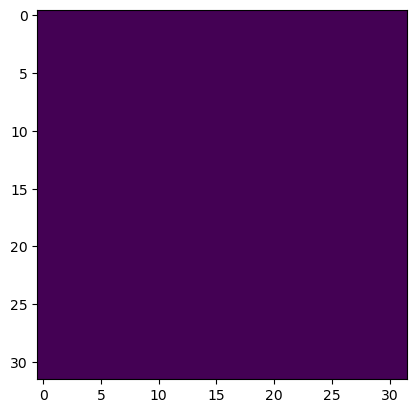

100%|██████████| 10/10 [00:00<00:00, 27.79it/s]


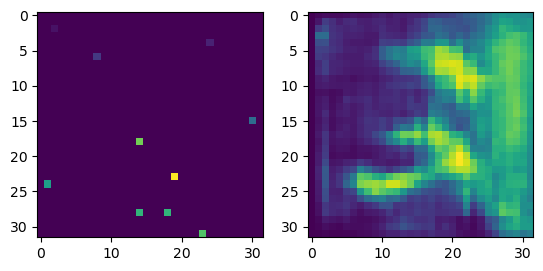

100%|██████████| 10/10 [00:00<00:00, 28.00it/s]


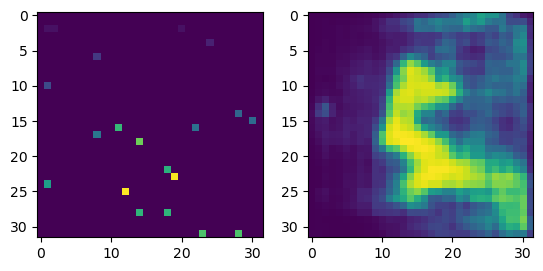

100%|██████████| 10/10 [00:00<00:00, 27.85it/s]


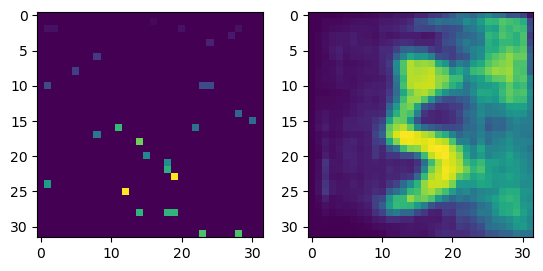

100%|██████████| 10/10 [00:00<00:00, 28.42it/s]


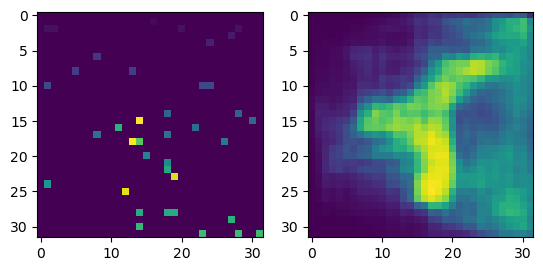

100%|██████████| 10/10 [00:00<00:00, 28.71it/s]


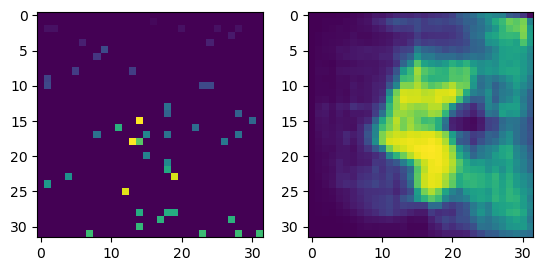

100%|██████████| 10/10 [00:00<00:00, 29.71it/s]


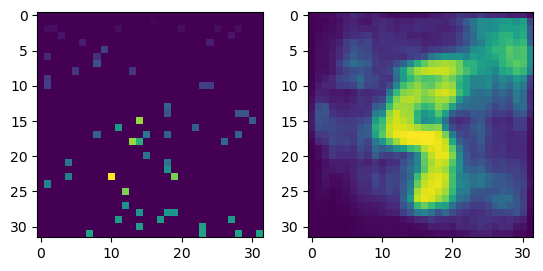

100%|██████████| 10/10 [00:00<00:00, 29.83it/s]


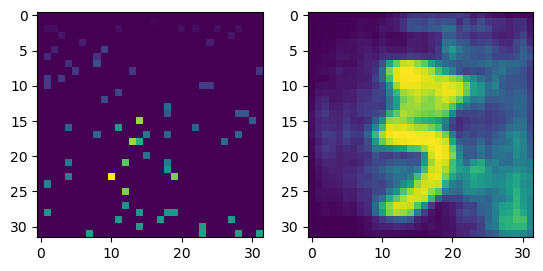

100%|██████████| 10/10 [00:00<00:00, 29.94it/s]


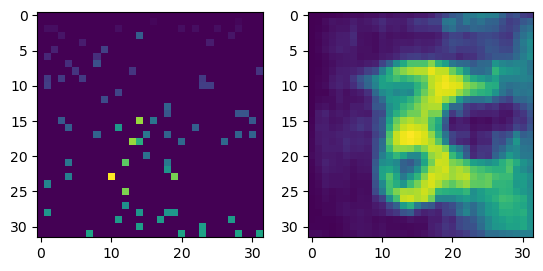

100%|██████████| 10/10 [00:00<00:00, 29.40it/s]


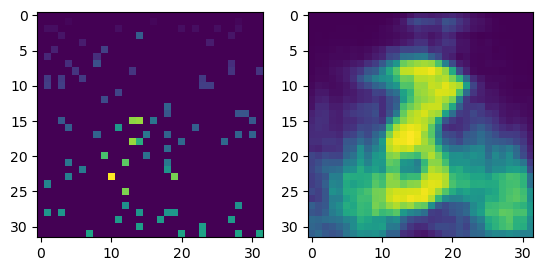

100%|██████████| 10/10 [00:00<00:00, 29.70it/s]


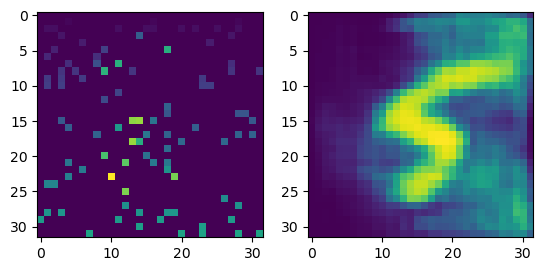

100%|██████████| 10/10 [00:00<00:00, 29.80it/s]


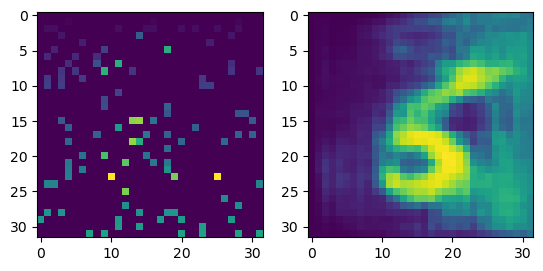

100%|██████████| 10/10 [00:00<00:00, 30.19it/s]


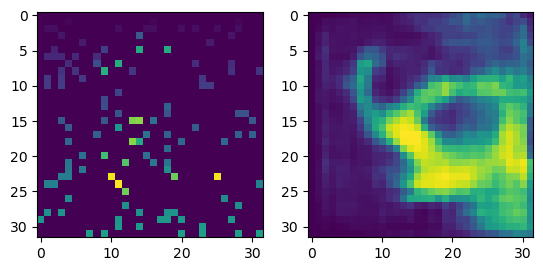

100%|██████████| 10/10 [00:00<00:00, 29.97it/s]


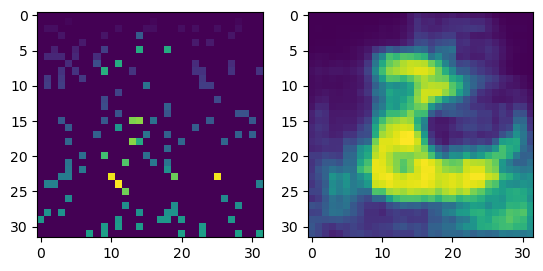

100%|██████████| 10/10 [00:00<00:00, 29.64it/s]


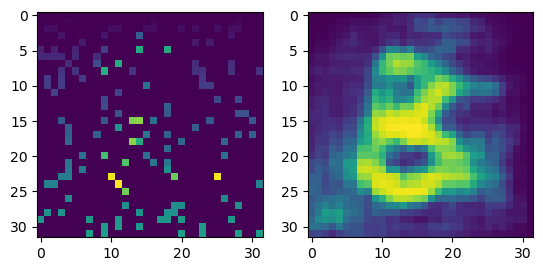

100%|██████████| 10/10 [00:00<00:00, 29.61it/s]


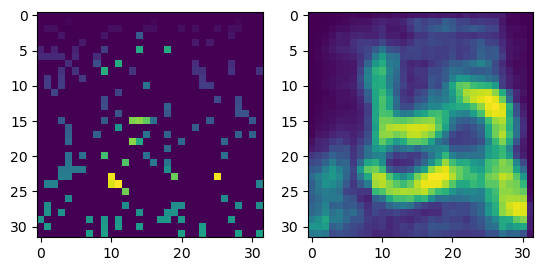

100%|██████████| 10/10 [00:00<00:00, 30.01it/s]


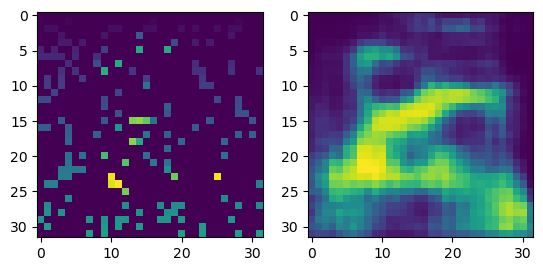

100%|██████████| 10/10 [00:00<00:00, 29.69it/s]


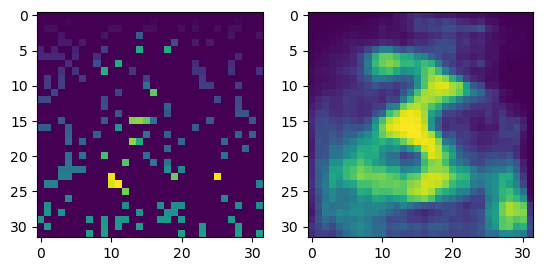

100%|██████████| 10/10 [00:00<00:00, 29.94it/s]


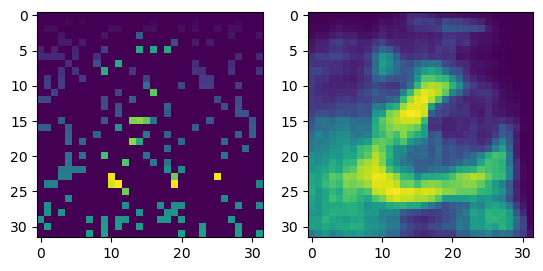

100%|██████████| 10/10 [00:00<00:00, 29.77it/s]


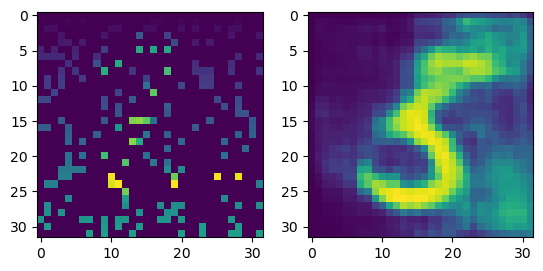

100%|██████████| 10/10 [00:00<00:00, 29.68it/s]


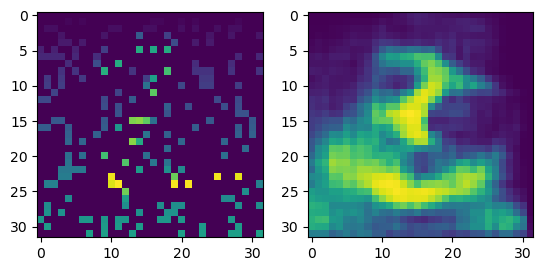

In [57]:
out1 = random_iteration(x)

In [58]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def thomospon_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    out = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.thomospon_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
        fig, axs= plt.subplots(1, 2)
        axs[0].imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        axs[1].imshow(rearrange(x_hat.cpu().detach().numpy(), "c h w -> (c h) w" ))
        plt.show()
    return out

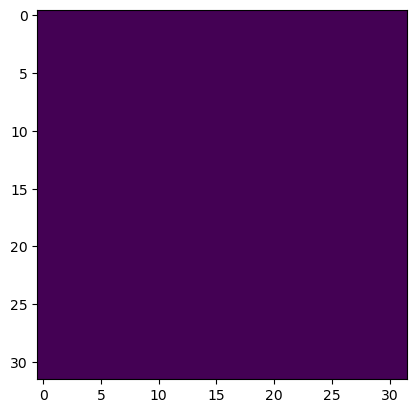

100%|██████████| 10/10 [00:00<00:00, 28.81it/s]


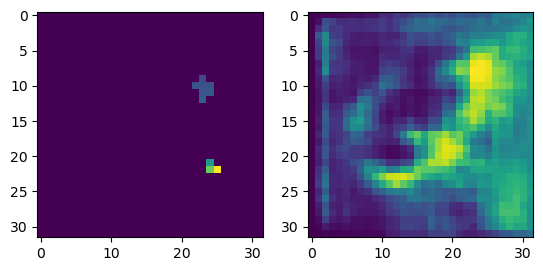

100%|██████████| 10/10 [00:00<00:00, 29.14it/s]


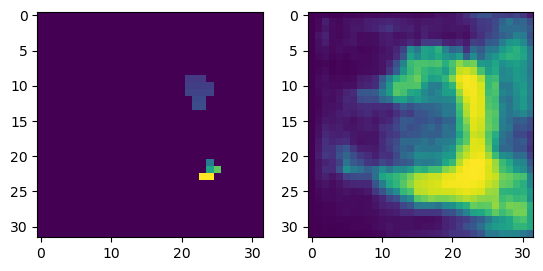

100%|██████████| 10/10 [00:00<00:00, 29.10it/s]


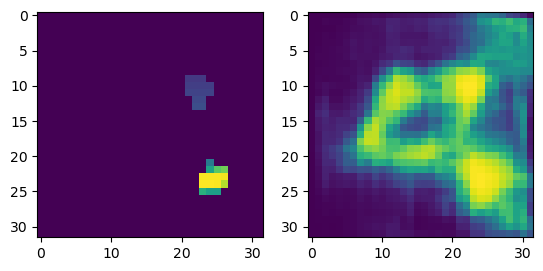

100%|██████████| 10/10 [00:00<00:00, 29.23it/s]


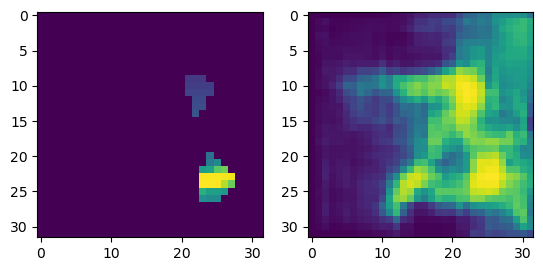

100%|██████████| 10/10 [00:00<00:00, 29.45it/s]


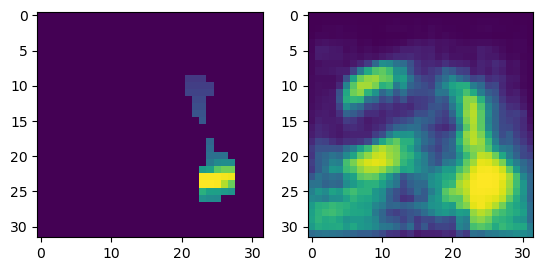

100%|██████████| 10/10 [00:00<00:00, 29.34it/s]


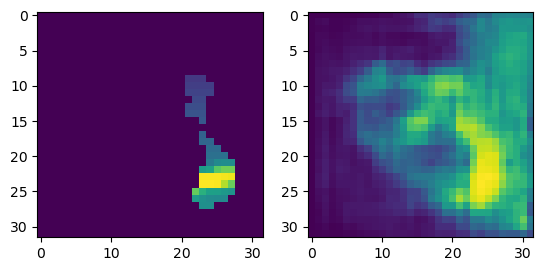

100%|██████████| 10/10 [00:00<00:00, 29.48it/s]


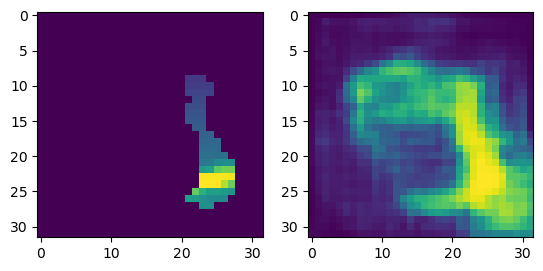

100%|██████████| 10/10 [00:00<00:00, 29.06it/s]


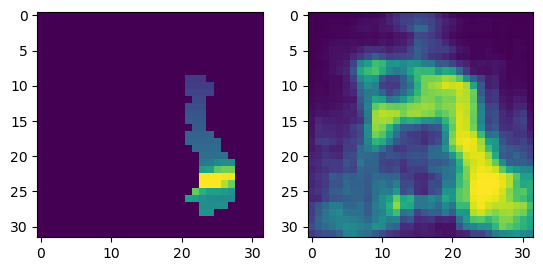

100%|██████████| 10/10 [00:00<00:00, 29.35it/s]


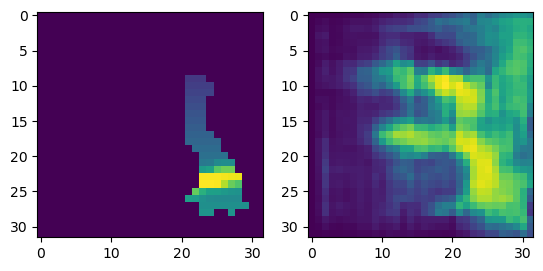

100%|██████████| 10/10 [00:00<00:00, 29.21it/s]


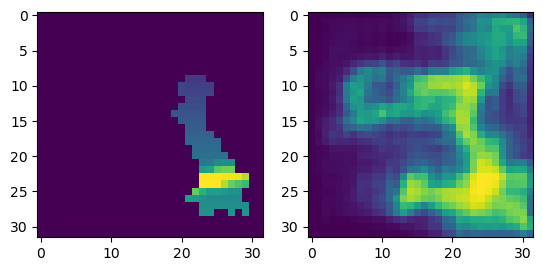

100%|██████████| 10/10 [00:00<00:00, 29.34it/s]


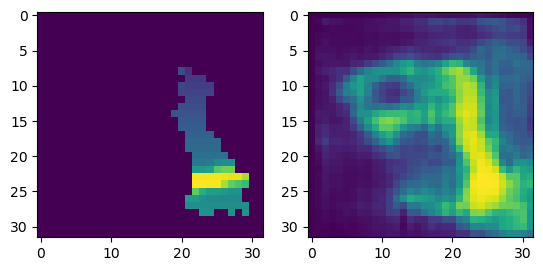

100%|██████████| 10/10 [00:00<00:00, 29.27it/s]


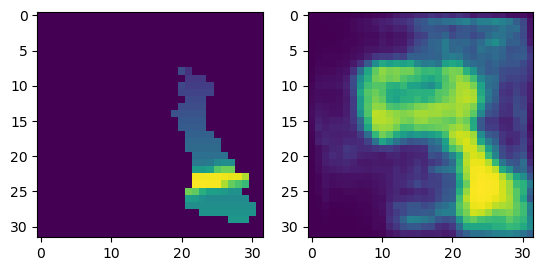

100%|██████████| 10/10 [00:00<00:00, 29.39it/s]


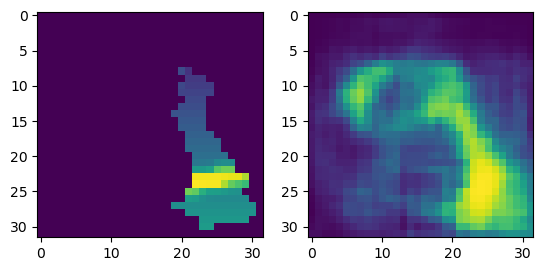

100%|██████████| 10/10 [00:00<00:00, 29.23it/s]


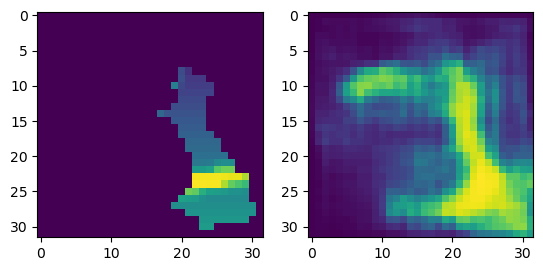

100%|██████████| 10/10 [00:00<00:00, 29.30it/s]


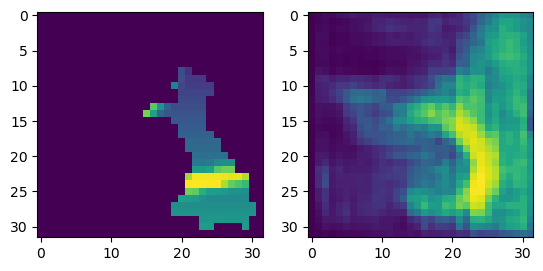

100%|██████████| 10/10 [00:00<00:00, 29.52it/s]


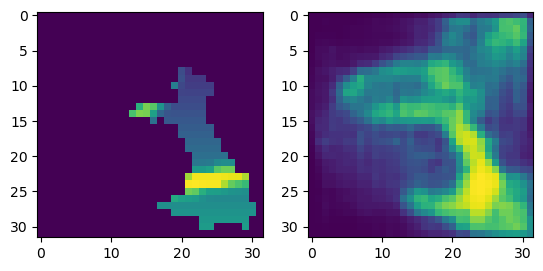

100%|██████████| 10/10 [00:00<00:00, 29.36it/s]


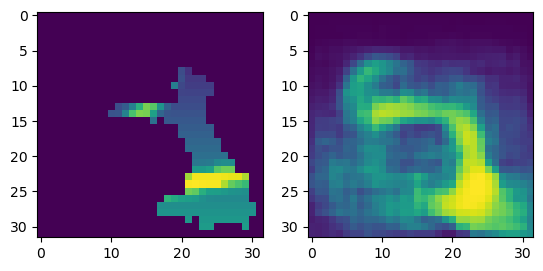

100%|██████████| 10/10 [00:00<00:00, 29.25it/s]


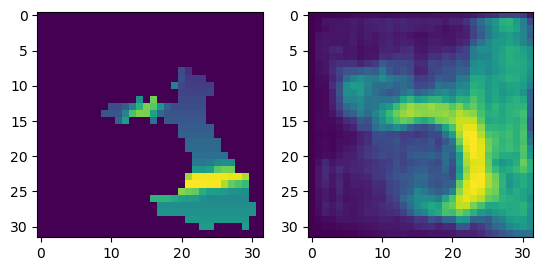

100%|██████████| 10/10 [00:00<00:00, 29.16it/s]


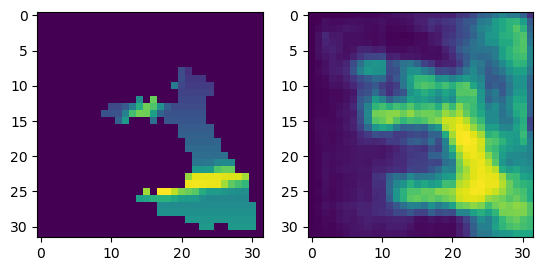

100%|██████████| 10/10 [00:00<00:00, 29.38it/s]


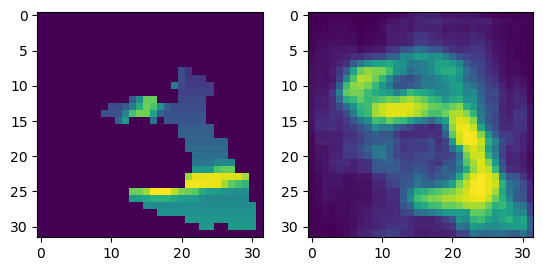

In [59]:
out2 = thomospon_iteration(x)

In [60]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image

def ucb_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    plt.imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
    plt.show()
    out= []
    n_samples = 10
    max_ = 0
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in trange(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.ucb_sample(imgs, k=50, num_pixels_per_samples=10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
        fig, axs= plt.subplots(1, 2)
        axs[0].imshow(rearrange(x_tilde.cpu(), "b c h w -> (b c h) w"))
        axs[1].imshow(rearrange(x_hat.cpu().detach().numpy(), "c h w -> (c h) w" ))
        plt.show()
    return out

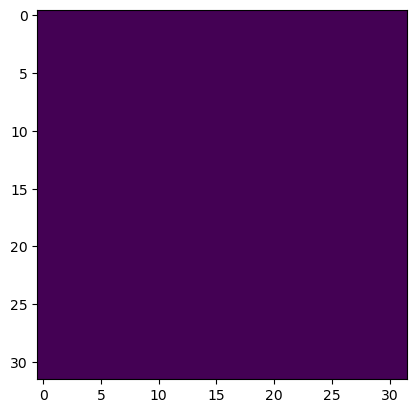

100%|██████████| 10/10 [00:00<00:00, 32.98it/s]


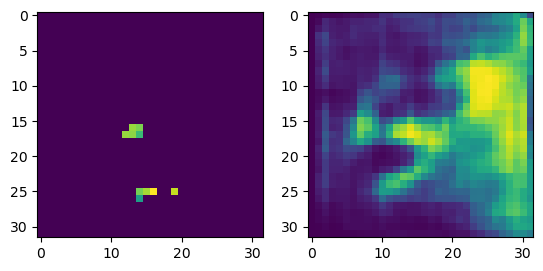

100%|██████████| 10/10 [00:00<00:00, 30.61it/s]


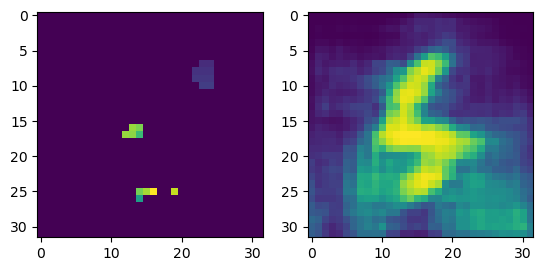

100%|██████████| 10/10 [00:00<00:00, 29.15it/s]


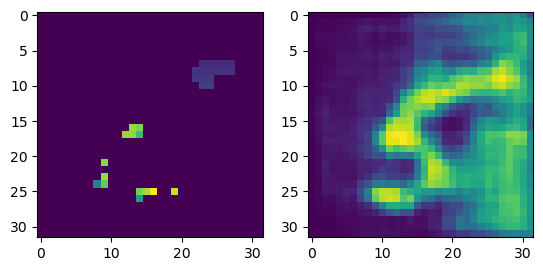

100%|██████████| 10/10 [00:00<00:00, 29.15it/s]


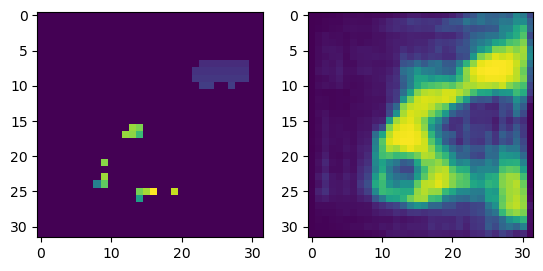

100%|██████████| 10/10 [00:00<00:00, 29.46it/s]


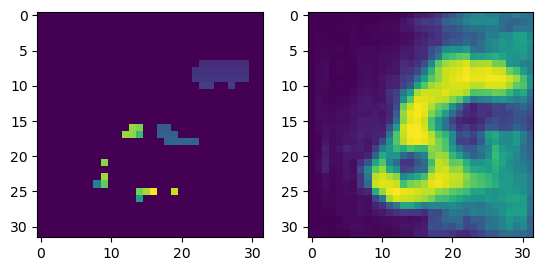

100%|██████████| 10/10 [00:00<00:00, 29.56it/s]


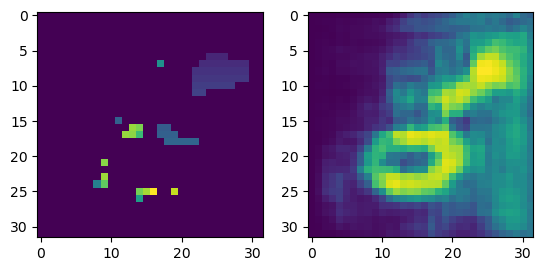

100%|██████████| 10/10 [00:00<00:00, 29.51it/s]


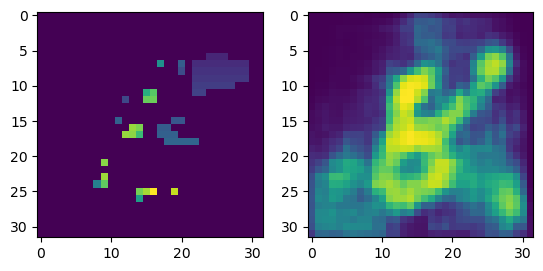

100%|██████████| 10/10 [00:00<00:00, 29.18it/s]


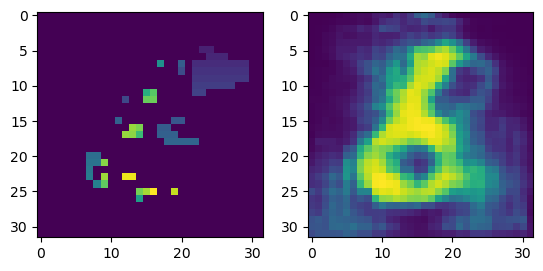

100%|██████████| 10/10 [00:00<00:00, 29.56it/s]


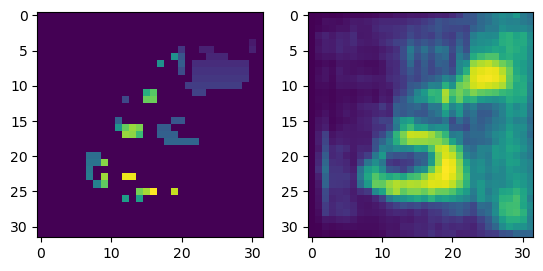

100%|██████████| 10/10 [00:00<00:00, 29.45it/s]


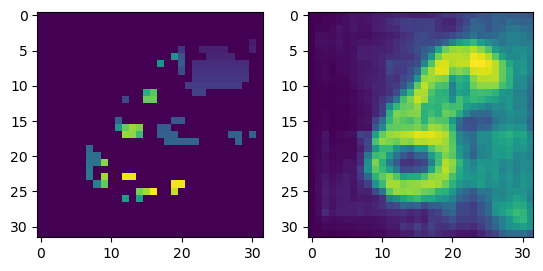

100%|██████████| 10/10 [00:00<00:00, 29.50it/s]


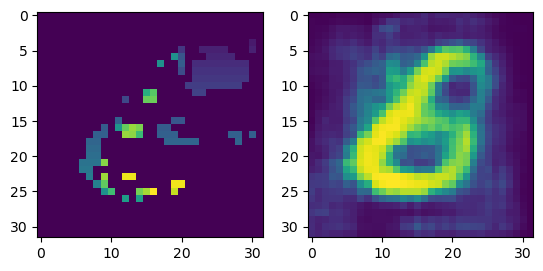

100%|██████████| 10/10 [00:00<00:00, 29.83it/s]


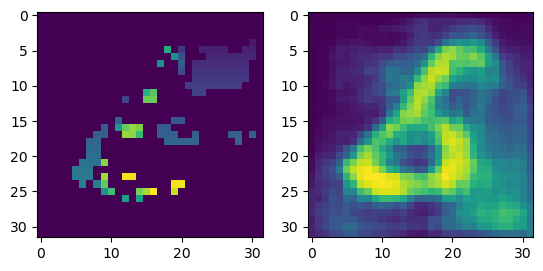

100%|██████████| 10/10 [00:00<00:00, 29.29it/s]


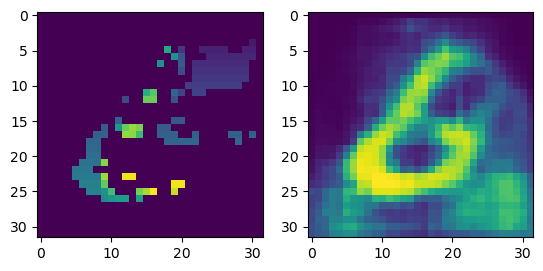

100%|██████████| 10/10 [00:00<00:00, 29.63it/s]


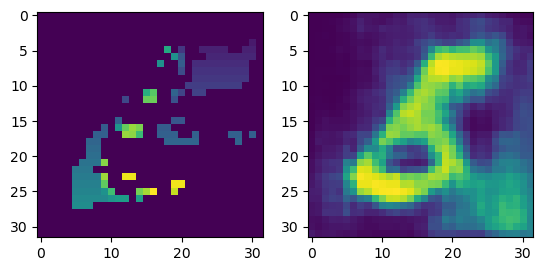

100%|██████████| 10/10 [00:00<00:00, 29.81it/s]


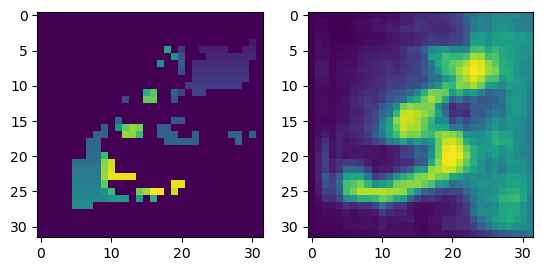

100%|██████████| 10/10 [00:00<00:00, 30.06it/s]


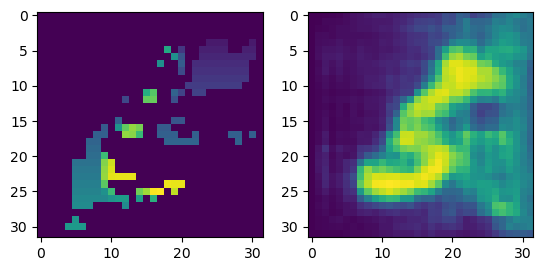

100%|██████████| 10/10 [00:00<00:00, 29.75it/s]


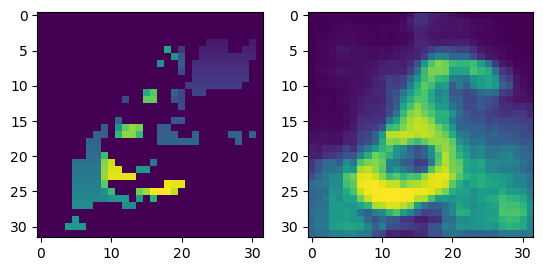

100%|██████████| 10/10 [00:00<00:00, 29.75it/s]


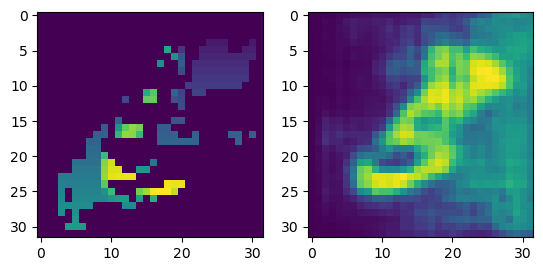

100%|██████████| 10/10 [00:00<00:00, 29.63it/s]


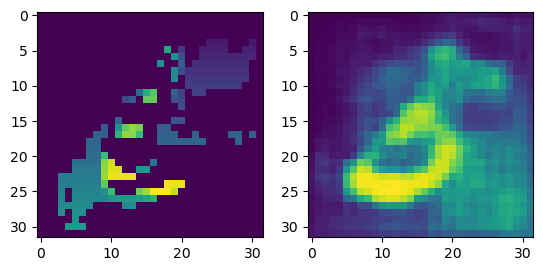

100%|██████████| 10/10 [00:00<00:00, 29.34it/s]


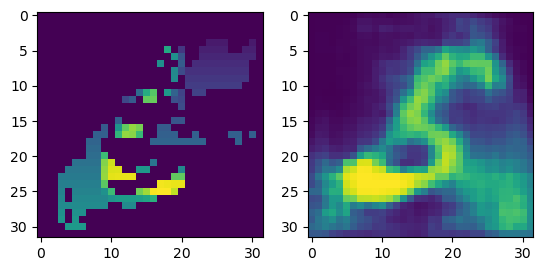

In [61]:
out3= ucb_iteration(x)

In [63]:
# The idea here is to first take 100 estimation and then take the avg of all 100 different estimate error for a single image
def ucb_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    out= []
    n_samples = 10
    max_ = 0
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in range(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.ucb_sample(imgs, k=50, num_pixels_per_samples=10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
    return out

def random_pick_iteration(img):
    dm = multi_mnist_dataloader_train(config, path=path, shuffle=True)
    config["exp_params"]["batch_size"] = 1
    out = []
    for i in range(20):
        gen = iter(dm)
        x, y = next(gen)
        x = x.to("cuda")
        adapt = make_adaptive_experiment(config)
        ri, A = adapt.random_pick_sample(x, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(img)
        if not out:
            out2 = torch.max(x_tilde).cpu().detach()
        else:
            out2 = max(torch.max(x_tilde).cpu().detach(), out[-1])
        out.append(out2)
    return out

def thomospon_iteration(x):
    adapt = make_adaptive_experiment(config)
    x_tilde = adapt.ebm.operator(x)
    out = []
    n_samples = 10
    for i in range(20):
        imgs = torch.zeros(n_samples, 32, 32)
        x_tilde = adapt.ebm.operator(x)
        for num in range(0, n_samples):
            x_hat = rearrange(adapt.ebm(x_tilde), "b c h w -> (b c) h w")
            imgs[num, : , :] = x_hat
        ri, A = adapt.thomospon_sample(imgs, 10)
        adapt.update_operator(A)
        x_tilde = adapt.ebm.operator(x)
        out.append(torch.max(x_tilde).cpu().detach())
    return out

In [64]:
fig, axs = plt.subplots(5, 5, figsize=(50, 50))
for l in trange(5):
    for t in range(5):
        x, y = next(gen)
        x = x.to("cuda")
        ucb=  ucb_iteration(x)
        thomospon = thomospon_iteration(x)
        random = random_pick_iteration(x)
        axs[l, t].plot(random)
        axs[l, t].plot(ucb)
        axs[l, t].plot(thomospon)
        axs[l, t].legend(['random sampling','thomospon sampling', 'ucb sampling'])
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]